## Imports Here

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import os
import random
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class CustomPalmOilDataset(Dataset):
    def __init__(self, root_dir='./Palm_Oil_Dataset/', transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_paths = []
        self.labels = []

        # Assuming 'Pure' corresponds to label 0 and 'Adulterated' corresponds to label 1
        label_mapping = {'Pure': 0, 'Adulterated': 1}

        for label_folder in os.listdir(root_dir):
            label = label_mapping.get(label_folder, -1)  # Assign -1 if folder not in mapping
            if label != -1:
                label_folder_path = os.path.join(root_dir, label_folder)
                for image_name in os.listdir(label_folder_path):
                    image_path = os.path.join(label_folder_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(label)


        combined_data = list(zip(self.image_paths, self.labels))
        random.shuffle(combined_data)
        self.image_paths, self.labels = zip(*combined_data)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label




transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])




In [3]:
test_size = 0.2  # You can adjust the test size as needed
random_seed = 42  # Set a seed for reproducibility
batch_size = 32

dataset = CustomPalmOilDataset(transform=transform)

# Define the percentage split for training and testing
train_percentage = 0.8  # 80% for training, 20% for testing
dataset_size = len(dataset)
train_size = int(train_percentage * dataset_size)
test_size = dataset_size - train_size

# Split the dataset into train and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## See a sample

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
(224, 224, 3)
img shape: (224, 224, 3), label shape: torch.Size([])


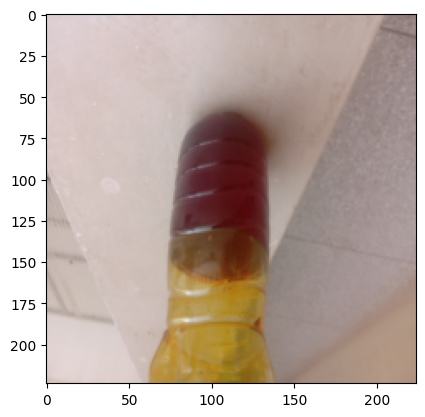

Label: 1


In [4]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


img = train_features[3].permute(1, 2, 0).numpy()
print(f"{img.shape}")
img = img.squeeze()
label = train_labels[0]

print(f"img shape: {img.shape}, label shape: {label.shape}")
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## CNN Model Creation

In [6]:
class PalmOilClassifier(nn.Module):
    def __init__(self):
        super(PalmOilClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*53*53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # Output has 2 units for binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer with 2 units for binary classification
        return x
    
model = PalmOilClassifier()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
for epoch in range(10):  # Loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print the loss for the current batch
        print(f'[{epoch + 1}, Batch {i + 1}] loss: {loss.item():.3f}')

        # Accumulate the running loss
        running_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(train_dataloader)
    print(f'[{epoch + 1}] Epoch loss: {average_loss:.3f}')
    running_loss = 0.0

print('Finished Training')


[1, Batch 1] loss: 0.692
[1, Batch 2] loss: 0.703
[1, Batch 3] loss: 0.676
[1, Batch 4] loss: 0.662
[1, Batch 5] loss: 0.627
[1, Batch 6] loss: 0.606
[1, Batch 7] loss: 0.625
[1, Batch 8] loss: 0.591
[1, Batch 9] loss: 0.520
[1, Batch 10] loss: 0.513
[1, Batch 11] loss: 0.502
[1, Batch 12] loss: 0.572
[1, Batch 13] loss: 0.450
[1, Batch 14] loss: 0.374
[1, Batch 15] loss: 0.386
[1] Epoch loss: 0.567
[2, Batch 1] loss: 0.476
[2, Batch 2] loss: 0.402
[2, Batch 3] loss: 0.317
[2, Batch 4] loss: 0.516
[2, Batch 5] loss: 0.521
[2, Batch 6] loss: 0.530
[2, Batch 7] loss: 0.344
[2, Batch 8] loss: 0.302
[2, Batch 9] loss: 0.384
[2, Batch 10] loss: 0.274
[2, Batch 11] loss: 0.312
[2, Batch 12] loss: 0.286
[2, Batch 13] loss: 0.171
[2, Batch 14] loss: 0.304
[2, Batch 15] loss: 0.356
[2] Epoch loss: 0.366
[3, Batch 1] loss: 0.255
[3, Batch 2] loss: 0.418
[3, Batch 3] loss: 0.367
[3, Batch 4] loss: 0.237
[3, Batch 5] loss: 0.242
[3, Batch 6] loss: 0.209
[3, Batch 7] loss: 0.237
[3, Batch 8] loss: 